<a href="https://colab.research.google.com/github/Aithu-Snehith/End-to-End-Learning-of-Communications-Systems-Without-a-Channel-Model/blob/master/8_pam_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries required for the implementation

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn import preprocessing
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

## Hyper Parameters

In [0]:
#length of message space
msg_total = 8
# number of channels
channel = 16
# number of epochs
epochs = 10000
# peturbation variance
sigma = 1e-4
# Batch size
batch_size = 1024

## Defining Required Functions

In [0]:
# Peturbation Sampling
def perturbation(x):
    w = K.random_normal(shape = (channel,2), mean=0.0,stddev=sigma**0.5,dtype=None)
    xp = ((1-Pert_variance)**0.5)*x + w
    return xp

# Defining transmitter loss
def loss_tx(y_true, y_pred):
    return -y_true*y_pred

# Defining the policy
def get_policy(inp):
    xp = inp[0]
    x = inp[1]
    w = xp - x
    policy = -K.sum(w*w)
    return policy

# Transmitter Model

##Defining Architecture

In [4]:
tx_inp = Input((1,))
# Adding embedding layer
embbedings_layer = Dense(msg_total, activation = 'relu')(tx_inp)
layer_dense = Dense(2*channel, activation = 'relu')(embbedings_layer)
# real to complex 
to_complex = Reshape((channel,2))(layer_dense)
# Normalising the output to unit energy
x = Lambda(lambda x: keras.backend.l2_normalize(x))(to_complex)
# Peturbation sampling 
xp = Lambda(perturbation)(to_complex)
policy = Lambda(get_policy)([xp,x])

Instructions for updating:
Colocations handled automatically by placer.


## Creating Required models ( outputs from required layers)

In [5]:
# model for policy training
model_policy = keras.models.Model(inputs=tx_inp, outputs=policy)
# model to get the peturbatated output
model_tx = keras.models.Model(inputs=tx_inp, outputs=xp)
# model to get the encoded message to transmit
model_x = keras.models.Model(inputs=tx_inp, outputs=x)

model_policy.compile(loss=loss_tx, optimizer=tf.keras.optimizers.SGD(lr = 1e-5))
print(model_policy.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            16          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           288         dense[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 16, 2)        0           dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

# Receiver

##Defining Architecture

In [6]:
rx_inp = Input((channel,2))
# complex to real
to_flat = Reshape((2*channel,))(rx_inp)
fc = Dense(8*2*channel, activation = 'relu')(to_flat)
softmax = Dense(msg_total, activation = 'softmax')(fc)

model_rx = keras.models.Model(inputs=rx_inp, outputs=softmax)

model_rx.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam())
print(model_rx.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 2)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 10,504
Trainable params: 10,504
Non-trainable params: 0
_________________________________________________________________
None


## Alternative Training

In [7]:
loss_tx = []
loss_rx = []
for epoch in range(epochs):
#     trasmitter training
#     generating input
    raw_input = np.random.randint(0,msg_total,(batch_size))
#     Generating labels
    label = np.zeros((batch_size, msg_total))
    label[np.arange(batch_size), raw_input] = 1
    tx_input = raw_input/float(msg_total)
#     Transmitter prediction ( message encoding )
    xp = model_tx.predict(tx_input)
#     Adding noise ( modelling AWGN layer)
    y = xp + np.random.normal(0,0.001,(batch_size, channel,2))
#     Decoding the message
    pred = model_rx.predict(y)
#     Getting loss
    loss = np.sum(np.square(label - pred), axis = 1)
#     Transmitter model training
    history_tx = model_policy.fit(tx_input, loss, batch_size=batch_size, epochs=1, verbose=0)    
    loss_tx.append(history_tx.history['loss'][0])
    
#     Receiver Training
    raw_input = np.random.randint(0,msg_total,(batch_size))
    label = np.zeros((batch_size, msg_total))
    label[np.arange(batch_size), raw_input] = 1
    tx_input = raw_input/float(msg_total)
    x = model_x.predict(tx_input)
    y = x + np.random.normal(0,0.001,(batch_size, channel,2))
    history_rx = model_rx.fit(y, label, batch_size=batch_size, epochs=1, verbose=0)
    loss_rx.append(history_rx.history['loss'][0])
    
#     Printing only after 100 epochs
    if(epoch % 100 == 0):
        print('epoch: ', epoch, 'tx_loss', history_tx.history['loss'][0], 'rx_loss', history_rx.history['loss'][0])

Instructions for updating:
Use tf.cast instead.
epoch:  0 tx_loss 111.65034484863281 rx_loss 2.075446128845215
epoch:  100 tx_loss 4.3518385887146 rx_loss 1.5956542491912842
epoch:  200 tx_loss 3.1458160877227783 rx_loss 1.3446216583251953
epoch:  300 tx_loss 2.183445930480957 rx_loss 1.0681068897247314
epoch:  400 tx_loss 2.750500440597534 rx_loss 0.8244391679763794
epoch:  500 tx_loss 3.4527690410614014 rx_loss 0.6615206003189087
epoch:  600 tx_loss 3.9687094688415527 rx_loss 0.5484654307365417
epoch:  700 tx_loss 4.75673246383667 rx_loss 0.44556933641433716
epoch:  800 tx_loss 2.3664300441741943 rx_loss 0.4057242274284363
epoch:  900 tx_loss 3.823850393295288 rx_loss 0.34978848695755005
epoch:  1000 tx_loss 4.562586784362793 rx_loss 0.3229084312915802
epoch:  1100 tx_loss 5.9120283126831055 rx_loss 0.2832150459289551
epoch:  1200 tx_loss 3.35794734954834 rx_loss 0.2697519361972809
epoch:  1300 tx_loss 2.7322275638580322 rx_loss 0.21645428240299225
epoch:  1400 tx_loss 4.766214370727

## Plotting the Transmitter and Receiver Loss

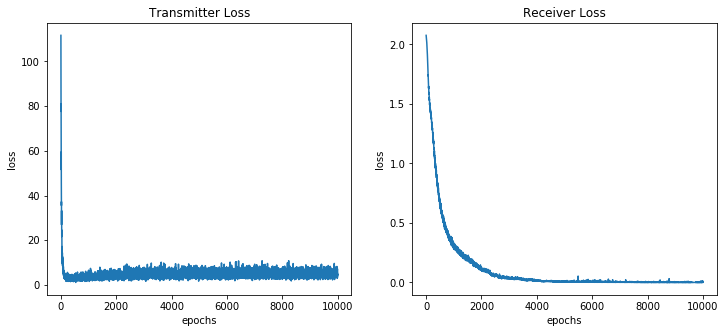

In [8]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(loss_tx)
plt.title('Transmitter Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.plot(loss_rx)
plt.title('Receiver Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Prediction

In [9]:
#testing
batch_size = 100
raw_input = np.random.randint(0,msg_total,(batch_size))
print('Transmitter Signal:',raw_input)
label = np.zeros((batch_size, msg_total))
label[np.arange(batch_size), raw_input] = 1
tx_input = raw_input/float(msg_total)
xp = model_x.predict(tx_input)
y = xp + np.random.normal(0,0.001,(batch_size, channel,2))
pred = model_rx.predict(y)
pred_int = np.argmax(pred, axis = 1)
print('Receiver Signal:',pred_int)


print('accuracy:',accuracy_score(raw_input, pred_int))

Transmitter Signal: [7 0 0 6 6 4 6 5 6 4 5 0 3 7 3 6 0 0 6 3 6 6 2 4 0 1 5 0 4 2 7 0 4 7 1 7 1
 7 7 5 5 7 4 4 0 1 3 3 6 4 0 0 6 6 5 6 5 3 1 0 0 7 5 3 1 4 4 6 2 5 1 4 5 6
 3 4 2 7 2 7 2 6 0 2 5 0 3 0 5 7 2 0 2 3 6 6 3 0 7 3]
Receiver Signal: [7 0 0 6 6 4 6 5 6 4 5 0 3 7 3 6 0 0 6 3 6 6 2 4 0 1 5 0 4 2 7 0 4 7 1 7 1
 7 7 5 5 7 4 4 0 1 3 3 6 4 0 0 6 6 5 6 5 3 1 0 0 7 5 3 1 4 4 6 2 5 1 4 5 6
 3 4 2 7 2 7 2 6 0 2 5 0 3 0 5 7 2 0 2 3 6 6 3 0 7 3]
accuracy: 1.0
